# Reuters News Text Classification
By: Cole Wagner, Haiyan Cai, and Joe Sellett

In [1]:
import zipfile
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import reuters
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


## Data Preparation

### Data Splitting Justification

We plan on splitting our data in a standard 80/20 train/test split. This approach is appropriate given that we have approximately 11,000 observations, which provides sufficient data to reserve 20% for testing without sacrificing model reliability. Additionally, even our lowest frequency class will maintain a few hundred observations after the split, which we believe is more than adequate for training a robust model. In our dataset, the classes represent different topics of documents, with each observation corresponding to a document labeled by its topic. This structure is common in text classification tasks, where the goal is to classify documents into predefined categories based on their content. This train/test split method mirrors common industry practices, where a significant portion of data is reserved for testing to ensure the model generalizes well to unseen data. By using this approach, we replicate a realistic scenario in which an algorithm is trained on a large dataset and evaluated on a held-out set, ensuring that performance metrics reflect real-world deployment conditions.

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(
    seed=7324,
    test_split=0.2,
)

In [3]:
reuters_index = reuters.get_word_index(path="reuters_word_index.json")

In [4]:
# Map the words to their indices
word_index = {k: (v + 3) for k, v in reuters_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<OOV>"] = 2

# Convert x_train from integer data to text data
reverse_word_index = {value: key for key, value in word_index.items()}
x_train_text = [
    " ".join([reverse_word_index.get(i, "<OOV>") for i in sequence])
    for sequence in x_train
]

# Convert x_test from integer data to text data
x_test_text = [
    " ".join([reverse_word_index.get(i, "<OOV>") for i in sequence])
    for sequence in x_test
]

First, we want to visually inspect the length of the texts in the data to determine which length to standardize to.

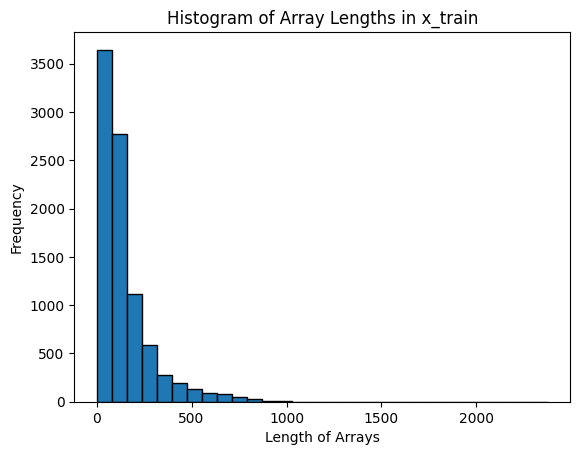

In [5]:
# Calculate the lengths of each array in x_train
x_train_lengths = [len(sequence) for sequence in x_train]

# Plot the histogram
plt.hist(x_train_lengths, bins=30, edgecolor="black")
plt.title("Histogram of Array Lengths in x_train")
plt.xlabel("Length of Arrays")
plt.ylabel("Frequency")
plt.show()

Next we want to visually inspect the distribution of the labels in the data to determine if there is a class imbalance problem. If there is, we will need to take steps to address it.

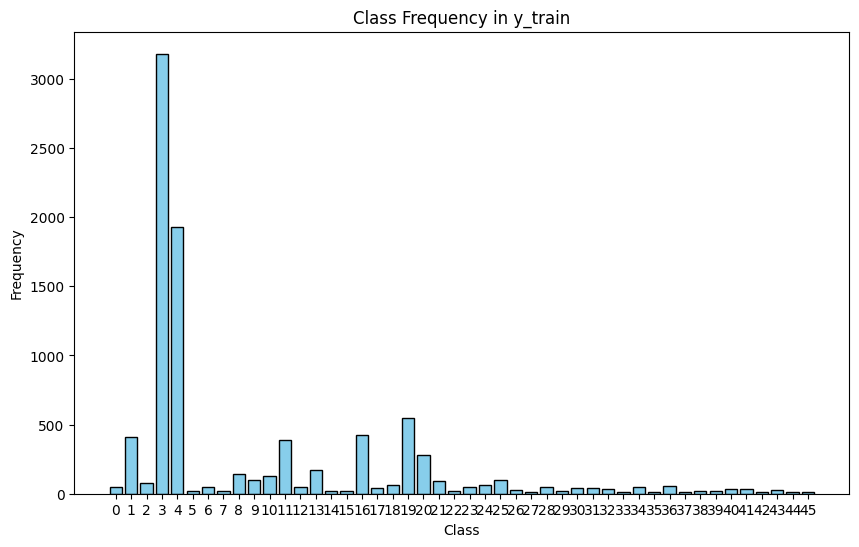

In [6]:
# Count the frequency of each class in y_train
class_counts = Counter(y_train)

# Extract classes and their frequencies
classes = list(class_counts.keys())
frequencies = list(class_counts.values())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, frequencies, color="skyblue", edgecolor="black")
plt.title("Class Frequency in y_train")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(classes)
plt.show()

Given that our dataset includes 46 classes, we opted to reduce the number to a more manageable subset for analysis. To achieve this, we employed a histogram to identify the most frequently occurring classes within the data. Upon reviewing the results, we observed that approximately eight classes were significantly more prevalent than the others. As a result, we chose to proceed with these eight classes, while consolidating the remaining classes into a single category labeled “other.”

In [7]:
# Find the frequency of labels in the training set
class_counts = Counter(y_train)

# Find the 8 most common labels
most_common_labels = class_counts.most_common(8)
most_common_labels

[(np.int64(3), 3181),
 (np.int64(4), 1931),
 (np.int64(19), 551),
 (np.int64(16), 426),
 (np.int64(1), 411),
 (np.int64(11), 391),
 (np.int64(20), 282),
 (np.int64(13), 173)]

In [8]:
# Keep only the most common labels and create "other" label
most_common_labels = dict(most_common_labels)
# Create a new list of labels
trunc_y_train = []
for label in y_train:
    if label in most_common_labels:
        trunc_y_train.append(label)
    else:
        trunc_y_train.append(0)

trunc_y_test = []
for label in y_test:
    if label in most_common_labels:
        trunc_y_test.append(label)
    else:
        trunc_y_test.append(0)


### Tokenization Strategy

We are using GloVe embeddings to convert words into dense vector representations, capturing semantic relationships for effective text classification. To prepare the data, we tokenize each document into words and enforce a fixed sequence length by padding shorter sequences and truncating longer ones. This ensures consistency in input size, making the data compatible with neural networks while managing computational efficiency.

### Evaluation Metric

Since there is no misclassification in our dataset that we consider significantly worse than another, we believe that accuracy remains a reasonable metric for evaluating model performance. However, accuracy alone does not provide a complete view of the model’s effectiveness, especially when dealing with imbalanced classes. Therefore, we will also be examining additional metrics, such as the F1 score, to gain a more comprehensive understanding of the model's performance, particularly in terms of its ability to balance precision and recall. This broader evaluation will help ensure that the model performs well across various aspects of classification. 

## Modeling

### Embedding Preparation

Credit: https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb for the following cell.

In [ ]:
NUM_TOP_WORDS = None  # use entire vocabulary!
MAX_ART_LEN = 1000  # maximum and minimum number of words

# tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(x_train_text)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(x_train_text)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS == None else NUM_TOP_WORDS
top_words = min((len(word_index), NUM_TOP_WORDS))
print(
    "Found %s unique tokens. Distilled to %d top words."
    % (len(word_index), top_words)
)

x = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(trunc_y_train)
print("Shape of data tensor:", x.shape)
print("Shape of label tensor:", y_ohe.shape)


Found 28180 unique tokens. Distilled to 28180 top words.
Shape of data tensor: (8982, 1000)
Shape of label tensor: (8982, 21)
28180


In [10]:
# Extract the GloVe embeddings
with zipfile.ZipFile("glove.6B.50d.zip", "r") as z:
    z.extractall(".")

Credit: https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb for the following cell.

In [ ]:
EMBED_SIZE = 50
embeddings_index = {}
f = Path.open("glove.6B.50d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

print(
    "Embedding Shape:",
    embedding_matrix.shape,
    "\n",
    "Total words found:",
    found_words,
    "\n",
    "Percentage:",
    100 * found_words / embedding_matrix.shape[0],
)

Found 400000 word vectors.
Embedding Shape: (28181, 50) 
 Total words found: 23093 
 Percentage: 81.94528228238885
CPU times: user 2.1 s, sys: 70.5 ms, total: 2.17 s
Wall time: 2.21 s


In [ ]:
# Create the embedding layer
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    weights=[embedding_matrix],
    trainable=False,
)

## Numberbatch vs. GloVe

In [14]:
# Map numberbatch embeddings

EMBED_SIZE = 300
embeddings_index = {}
f = Path.open("numberbatch.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

print(
    "Embedding Shape:",
    embedding_matrix.shape,
    "\n",
    "Total words found:",
    found_words,
    "\n",
    "Percentage:",
    100 * found_words / embedding_matrix.shape[0],
)

Found 516783 word vectors.
Embedding Shape: (28181, 300) 
 Total words found: 19100 
 Percentage: 67.77616124339093
